**NEXT STEPS**
* Reprendre le code du SIFT avec le TP vision dans le sandbox
* Intégrer l'étape de PCA + TSNE avant de calculer l'ARI sur les modèles CNN en transfer learning
* Score à atteindre : environ 0.70

In [1]:
# Importe EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize

from multiprocessing import Pool

In [2]:
%%capture
%run preprocessing.ipynb

# IMAGES

**RECUPERATION DES IMAGES DANS LE REPERTOIRE**

In [3]:
# Définition du chemin d'accès au répertoire contenant les images
path = "./Images/"

# Création de la liste contenant les chemins d'accès ordonnées
image_paths = [path + image for image in flipkart_filtered["image"]]

In [4]:
# Création d'un dataframe avec les dimensions de chaque image
res_frame = pd.DataFrame([cv2.imread(image_path).shape for image_path in image_paths])
res_frame.rename(columns={0: "height", 1: "width", 2: "channels"}, inplace=True)

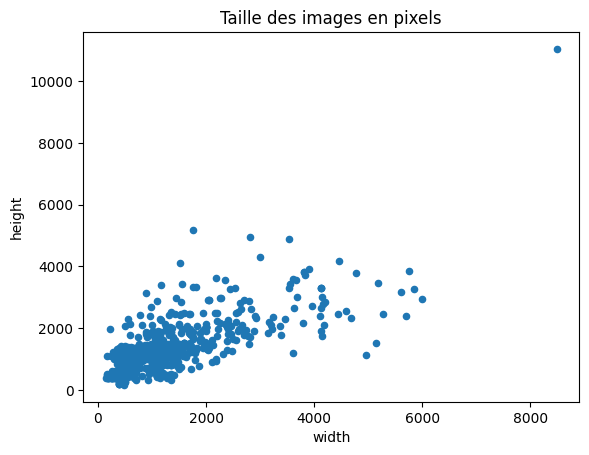

In [5]:
# Scatter plot de la taille des images
res_frame.filter(["height", "width"]).plot(kind='scatter', x='width', y='height')
plt.title("Taille des images en pixels")
plt.show()

**RESIZE DES IMAGES AVEC UNE FONCTION CUSTOM DE REDIMENSIONNEMENT**

In [6]:
def resizeAndPad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA

    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = float(w)/h 
    saspect = float(sw)/sh

    if (saspect > aspect) or ((saspect == 1) and (aspect <= 1)):  # new horizontal image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = float(sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0

    elif (saspect < aspect) or ((saspect == 1) and (aspect >= 1)):  # new vertical image
        new_w = sw
        new_h = np.round(float(new_w) / aspect).astype(int)
        pad_vert = float(sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0

    # set pad color
    if len(img.shape)==3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

**RESIZE DES IMAGES AVEC LA FONCTION RESIZE OPEN CV / TENSORFLOW / CUSTOM**

In [13]:
# Définition de la size pour le redimensionnement
size = (224, 224)

# Redimensionnement des images en 224x224 pixels en gardant l'aspect ratio
custom_224= np.array([resizeAndPad(cv2.imread(image_path), size, padColor=255) for image_path in tqdm(image_paths)])
# Redimensionnement des images en 224x224 pixels en gardant l'aspect ratio de tensorflow
opencv_224 = np.array([cv2.resize(cv2.imread(image_path), size) for image_path in tqdm(image_paths)])
# Redimensionnement des images en 224x224 pixels en gardant l'aspect ratio de tensorflow
tf_224 = np.array([resize(cv2.imread(image_path), size) for image_path in tqdm(image_paths)])

In [15]:
# Définition de la size pour le redimensionnement
size = (336, 336)

# Redimensionnement des images en 336, 336 pixels en gardant l'aspect ratio
custom_336= np.array([resizeAndPad(cv2.imread(image_path), size, padColor=255) for image_path in tqdm(image_paths)])
# Redimensionnement des images en 336, 336 pixels en gardant l'aspect ratio de tensorflow
opencv_336 = np.array([cv2.resize(cv2.imread(image_path), size) for image_path in tqdm(image_paths)])
# Redimensionnement des images en 336, 336 pixels en gardant l'aspect ratio de tensorflow
tf_336 = np.array([resize(cv2.imread(image_path), size) for image_path in tqdm(image_paths)])

100%|██████████| 1050/1050 [00:22<00:00, 47.67it/s]


## CNN

In [82]:
def ARI_cnn(images, n_clusters=7, preprocessing=True):
    # Crée un data generator pour les images
    if preprocessing:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    else:
        datagen=ImageDataGenerator()

    # Crée le data generator
    datagenerator = datagen.flow(
        images,
        batch_size=32,
        shuffle=False  # Ne pas mélanger les images pour pouvoir les retrouver plus tard lors du calcul de l'adjusted rand score
    )
    # Crée les embeddings
    embeddings = embedding_model.predict(datagenerator)
    # Affiche la taile des embeddings
    print('Raw shape: ', embeddings.shape)
    embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)
    print('Flat shape: ', embeddings_flat.shape)

    # Réduction de la dimensionnalité des embeddings
    pca = PCA(n_components=0.95)

    # Fit et transforme les embeddings
    embeddings_pca = pca.fit_transform(embeddings_flat)
    # Affiche la taille des embeddings après PCA
    print('PCA shape: ', embeddings_pca.shape)

    # Crée le modèle KMeans
    n_clusters = n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings_pca)

    ari = adjusted_rand_score(flipkart_filtered['category_0'], clusters)
    print(f"Adjusted Rand Index: {ari}")
    return ari

In [37]:
ari_scores = []

### EFFICIENT NET CLASSIFICATION

Le modèle EfficientNetB0 est un modèle de convolution pré-entraîné sur ImageNet qui est capable de classifier des images en 1000 catégories.<br>
Nous allons retirer la dernière couche du modèle et recréer une nouvelle couche de classification avec 7 classes qui correspondent aux catégories de produits.<br>


Commençons par charger le modèle EfficientNetB0 pré-entraîné sur ImageNet et retirer la dernière couche de classification:

In [9]:
# Charge le modèle sous la variable efficient_model
efficient_model = EfficientNetB0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
    )

In [11]:
%%capture
# Affiche l'architecture du modèle
efficient_model.summary()

Le modèle est composé d'un grand nombre de couche de convolution et de normalisation qui permettent d'extraire des features de plus en plus abstraites des images.<br>
Nous allons ajouter une couche de classification avec 7 neurones qui correspondent aux catégories de produits.

In [9]:
# On récupère l'output du modèle
x = efficient_model.output

In [10]:
# Ajout d'une couche de pooling suivant d'une couche FC puis d'une couche de classification à 7 classes
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(7, activation='softmax')(x)

In [11]:
# Création du modèle à jour avec les couches d'entrée d'efficient et les couches de sortie ajoutées
updated_model = Model(inputs=efficient_model.input, outputs=x)

In [12]:
# Paramètre les couches de l'input à trainable=False
for layer in efficient_model.layers:
    layer.trainable = False

In [13]:
# Compile le modèle
updated_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

A présent, pour entraîner notre modèle, nous allons devoir préparer nos données d'image pour les envoyer dans le modèle.<br>

In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [ ]:
train_datagen_wh = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    flipkart_filtered,
    directory=path,
    x_col='image',
    y_col='category_0',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 1050 validated image filenames belonging to 7 classes.


In [16]:
updated_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10
)

Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  9/100 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 0.1555 - loss: 1.9865

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 22/100 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - accuracy: 0.1515 - loss: 1.9810

KeyboardInterrupt: 

Les dimensions HxLxC du tenseur d'entrée sont 224x224x3.<br>
Je dois adapter toutes les images à ces dimensions pour pouvoir les envoyer dans le modèle CNN:

In [ ]:
# Création d'une liste qui contient toutes les images redimensionnées sous forme de batch



### EFFICIENT NET EMBEDDINGS

In [43]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

In [44]:
# Définition de la taille des images
size = (224, 224)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
eff_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
eff_model.output.shape

(None, 7, 7, 1280)

In [45]:
%%capture
eff_model.summary()

In [46]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = eff_model.get_layer('block7a_expand_conv')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(eff_model.input, last_conv_layer.output)

In [47]:
for image in tqdm([opencv_224, tf_224, custom_224]):
    ari_scores.append(ARI_cnn(image))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step 
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


 33%|███▎      | 1/3 [01:16<02:32, 76.11s/it]

PCA shape:  (1050, 666)
Adjusted Rand Index: 0.32339832231164917


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 741ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


 67%|██████▋   | 2/3 [02:05<01:00, 60.46s/it]

PCA shape:  (1050, 666)
Adjusted Rand Index: 0.3244894274108034


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 706ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


100%|██████████| 3/3 [03:00<00:00, 60.28s/it]

PCA shape:  (1050, 623)
Adjusted Rand Index: 0.17948141823801084


In [48]:
print(ari_scores)

[0.32339832231164917, 0.3244894274108034, 0.17948141823801084]


In [77]:
# Définition de la taille des images
size = (336, 336)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
eff_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
eff_model.output.shape

(None, 11, 11, 1280)

In [78]:
%%capture
eff_model.summary()

In [79]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = eff_model.get_layer('block7a_expand_conv')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(eff_model.input, last_conv_layer.output)

In [83]:
ARI_cnn(opencv_336, preprocessing=False)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)
PCA shape:  (1050, 743)
Adjusted Rand Index: 0.3556772032685982


0.3556772032685982

In [53]:
print(ari_scores)

[0.32339832231164917, 0.3244894274108034, 0.17948141823801084, 0.3556772032685982, 0.3556772032685982, 0.15248888772357608]


In [ ]:
# Définition de la taille des images
size = (336, 336)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
eff_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
eff_model.output.shape

(None, 11, 11, 1280)

In [ ]:
%%capture
eff_model.summary()

In [ ]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = eff_model.get_layer('block7a_expand_conv')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(eff_model.input, last_conv_layer.output)

In [ ]:
for image in tqdm([opencv_336, tf_336, custom_336]):
    ari_scores.append(ARI_cnn(image))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)
PCA shape:  (1050, 743)


 33%|███▎      | 1/3 [02:18<04:36, 138.43s/it]

Adjusted Rand Index: 0.3556772032685982


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)


 67%|██████▋   | 2/3 [04:20<02:08, 128.72s/it]

PCA shape:  (1050, 743)
Adjusted Rand Index: 0.3556772032685982


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
Raw shape:  (1050, 11, 11, 1152)
Flat shape:  (1050, 139392)


100%|██████████| 3/3 [06:15<00:00, 125.20s/it]

PCA shape:  (1050, 704)
Adjusted Rand Index: 0.15248888772357608


In [ ]:
print(ari_scores)

[0.32339832231164917, 0.3244894274108034, 0.17948141823801084, 0.3556772032685982, 0.3556772032685982, 0.15248888772357608]


### VGG16 EMBEDDINGS

In [96]:
ari_scores = []

In [97]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

In [98]:
# Définition de la taille des images
size = (224, 224)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle vgg16
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
vgg16_model.output.shape

(None, 7, 7, 512)

In [99]:
%%capture
vgg16_model.summary()

In [100]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = vgg16_model.get_layer('block5_conv3')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(vgg16_model.input, last_conv_layer.output)

In [102]:
ARI_cnn(opencv_224, preprocessing=False)

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step
Raw shape:  (1050, 14, 14, 512)
Flat shape:  (1050, 100352)
PCA shape:  (1050, 777)
Adjusted Rand Index: 0.12095135314160917


0.12095135314160917

In [95]:
for image in tqdm([opencv_224, tf_224, custom_224]):
    ari_scores.append(ARI_cnn(image, preprocessing=False))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/33 ━━━━━━━━━━━━━━━━━━━━ 4:02 8s/step

  0%|          | 0/3 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(ari_scores)

In [ ]:
# Définition de la taille des images
size = (336, 336)
channels = 3
w, h = size
input_shape = (w, h, channels)

# Création du modèle EfficientNetB0
# Création du modèle vgg16
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape,
)
# Print de l'output du modèle
vgg16_model.output.shape

(None, 11, 11, 1280)

In [ ]:
%%capture
vgg16_model.summary()

In [ ]:
#Choisir la dernière couche convolutive du modèle en output
last_conv_layer = vgg16_model.get_layer('block5_conv3')

# Créer le modèle qui prend en entrée l'image et qui renvoie les activations de la dernière couche convolutive
embedding_model = Model(vgg16_model.input, last_conv_layer.output)

In [ ]:
for image in tqdm([opencv_336, tf_336, custom_336]):
    ari_scores.append(ARI_cnn(image))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step 
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)
PCA shape:  (1050, 666)


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
 33%|███▎      | 1/3 [01:13<02:27, 73.52s/it]

Adjusted Rand Index: 0.32339832231164917


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 893ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


 67%|██████▋   | 2/3 [02:24<01:11, 71.75s/it]

PCA shape:  (1050, 666)
Adjusted Rand Index: 0.3244894274108034


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 719ms/step
Raw shape:  (1050, 7, 7, 1152)
Flat shape:  (1050, 56448)


100%|██████████| 3/3 [03:10<00:00, 63.63s/it]

PCA shape:  (1050, 623)
Adjusted Rand Index: 0.17948141823801084


In [ ]:
print(ari_scores)

### VGG16 CLASSIFICATION

In [8]:
vgg16_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [9]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
n_classes = flipkart_filtered['category_0'].nunique()

In [ ]:
x = vgg16_model.output

# Ajoute une couche de classification à 7 classes
x = Dense(n_classes, activation='softmax')(x)

In [ ]:
# Crée le modèle
vgg16 = Model(inputs=vgg16_model.input, outputs=x)

# Paramètre les couches de l'input à trainable=False pour ne pas réentraîner les poids et faire de l'extraction features
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
# Compile le modèle
vgg16.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## VISUAL BAG OF WORDS

In [ ]:
# Create a SIFT object to detect keypoints and extract descriptors
extractor = cv2.SIFT_create()



En résumé, charger une image en niveaux de gris est une pratique courante pour simplifier et optimiser le traitement d'images, en particulier pour des tâches où les informations de couleur ne sont pas essentielles.

La première méthode que je vais utiliser pour segmenter les images est la méthode de KMeans appliqué sur un Visual Bag of Words.<br>
Pour construire le Visual Bag of Words, je vais suivre les étapes suivantes :
- Extraire les features (keypoints + descriptors) des images avec SIFT.
- Regrouper les descriptors dans un nombre fini de clusters et identifier les centroids, qui formeront le corpus de nos mos visuels.
- Pour chaque image, utiliser le modèle KMeans pour attribuer un cluster à chaque descriptor SIFT.
- Le Visual Bow of Words contiendra dans les colonnes les centroids des clusters et dans les lignes la fréquence d'apparition de chaque centroid dans l'image.
- Enfin,nous ingérons le VBOW dans notre fonction de calcul de l'ARI en utilisant le KMeans à nouveau et obtenir la segmentation visuelle en 2D avec le TSNE.

La colonne `image`dans le dataframe `flipkart_filtered`contient l'ordre d'apparition des images.<br>
Nous allons spécifiquement recréer la liste des chemins de fichier en utilisant cet ordre :

In [ ]:
# Définition du chemin d'accès au répertoire contenant les images
path = "./Images/"

# Création de la liste contenant les chemins d'accès ordonnées
image_paths = [path + image for image in flipkart_filtered["image"]]

Nous pouvons maintenant passer à l'étape d'extraction des features SIFT pour chaque image.<br>
Nous allons créer une liste contenant tous les descripteurs SIFT pour chaque image que nous pourrons réutiliser par la suite :

In [ ]:
def extract_sift_features(image_path, resize_2d=None):
    # Load the image in greyscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if resize_2d is not None:
        # Resize the image if not None
        image = cv2.resize(image, resize_2d)
    # Create a SIFT object to detect keypoints and extract descriptors
    extractor = cv2.SIFT_create()
    # Detect keypoints and extract descriptors
    keypoints, descriptors = extractor.detectAndCompute(image=image, mask=None)
    return descriptors

In [ ]:
# Crée une liste avec les descriptors SIFT sur les images de taille 224x224
sift_descriptors_resized = [extract_sift_features(image_path, (224, 224)) for image_path in tqdm(image_paths)]


100%|██████████| 1050/1050 [00:16<00:00, 62.63it/s]


In [ ]:
# Crée une liste avec les descriptors SIFT sur les images de taille originale
sift_descriptors_original = [extract_sift_features(image_path, (448, 448)) for image_path in tqdm(image_paths)]


100%|██████████| 1050/1050 [00:49<00:00, 21.00it/s]


In [1]:
# Empiler tous les descripteurs dans une seule grande matrice
pd.Series(sift_descriptors_original).apply(lambda x: x.reshape(1, -1))

NameError: name 'pd' is not defined

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Import Kmeans mini batch

In [ ]:
# Choisir le nombre de clusters (nombre de "mots visuels")
n_clusters = 500

# Appliquer KMeans sur les descripteurs combinés
kmeans = KMeans(n_clusters=n_clusters, random_state=314)
kmeans.fit(all_descriptors)

# Les centres des clusters seront tes "mots visuels"
visual_words = kmeans.cluster_centers_

In [ ]:
descriptors[0].reshape(1, -1).shape

(1, 128)

In [ ]:
histograms = []

for descriptors in tqdm(
    descriptor_list
):  # descriptor_list contient les descripteurs de chaque imag
    histogram = np.zeros(n_clusters)
    for descriptor in tqdm(descriptors):
        idx = kmeans.predict(descriptor.reshape(1, -1))
        histogram[idx] += 1

    histogram = histogram / np.sum(histogram)  # Normalisation optionnelle
    histograms.append(histogram)


100%|██████████| 1049/1049 [18:00<00:00,  1.03s/it]


In [ ]:
type(histograms)

list

In [ ]:
# Convert the histograms list into a DataFrame
histograms_df = pd.DataFrame(
    histograms, columns=[f"hist_{i}" for i in range(n_clusters)]
)

In [ ]:
# Use the ARIs function to compute the ARI between the true categories and the clusters
ARI, X_tsne, labels, y_cat_ser = ARI_fct(histograms_df)

ARI :  0.0021 time :  11.0


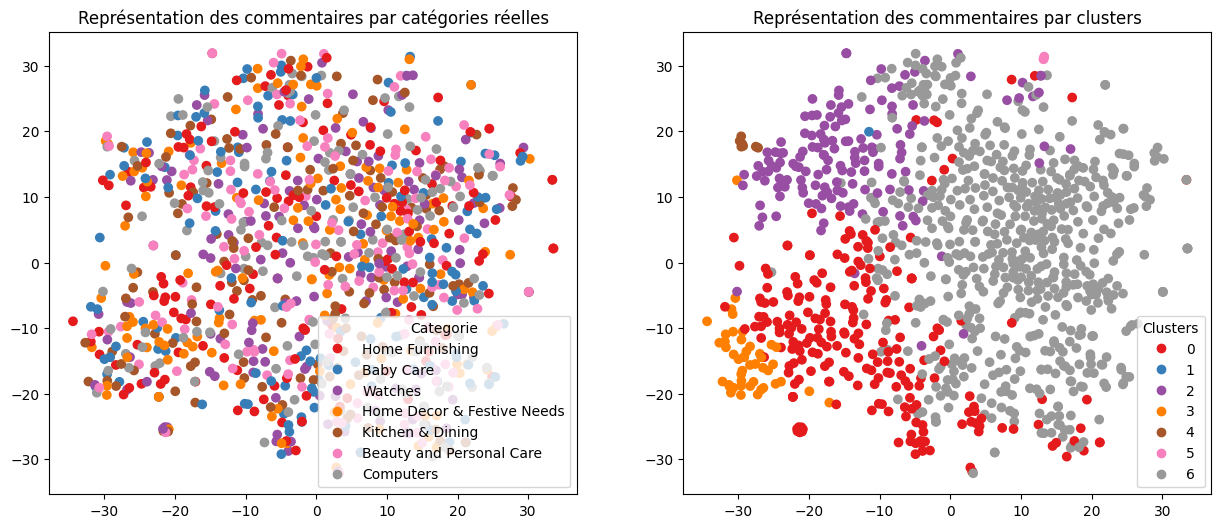

ARI :  0.0021


In [ ]:
# Use the TSNE_visu_fct function to visualize the TSNE
TSNE_visu_fct(X_tsne, y_cat_ser.tolist(), labels, ARI)

In [ ]:
histograms_df

,hist_0,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,...,hist_490,hist_491,hist_492,hist_493,hist_494,hist_495,hist_496,hist_497,hist_498,hist_499
0,0.000715,0.015376,0.000000,0.000536,0.000179,0.001967,0.000358,0.001609,0.000179,0.003218,...,0.001430,0.000536,0.000536,0.000000,0.000715,0.000894,0.001252,0.000358,0.001430,0.000894
1,0.001410,0.001410,0.004231,0.000000,0.000000,0.001410,0.001410,0.000000,0.000000,0.000000,...,0.000000,0.005642,0.002821,0.000000,0.000000,0.001410,0.000000,0.001410,0.000000,0.000000
2,0.002462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000615,0.000000,0.006769,0.000000,0.000000,0.000000,0.000000
3,0.002096,0.004612,0.001258,0.000000,0.001258,0.000000,0.000419,0.000000,0.000000,0.002096,...,0.000839,0.006709,0.000839,0.002096,0.000000,0.003354,0.002096,0.000419,0.000839,0.000839
4,0.007887,0.000415,0.000000,0.000000,0.000830,0.000415,0.000000,0.000830,0.000000,0.002491,...,0.000830,0.000000,0.013284,0.000000,0.000000,0.000000,0.000000,0.003736,0.000830,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,0.001564,0.000000,0.003128,0.001564,0.000000,0.004692,0.002086,0.000521,0.000000,0.001564,...,0.002086,0.002607,0.000521,0.002086,0.001564,0.002086,0.001564,0.002607,0.005214,0.003650
1045,0.000859,0.004294,0.001431,0.000000,0.002290,0.004008,0.002863,0.000000,0.000000,0.002004,...,0.004581,0.000859,0.000573,0.001431,0.001145,0.002004,0.001718,0.002577,0.002863,0.002577
1046,0.000000,0.000000,0.003448,0.000000,0.006897,0.000000,0.000000,0.000000,0.000000,0.003448,...,0.000000,0.001724,0.000000,0.001724,0.000000,0.001724,0.000000,0.003448,0.001724,0.003448
1047,0.004306,0.002936,0.000587,0.003719,0.001174,0.000196,0.000783,0.003719,0.000196,0.003523,...,0.002740,0.001370,0.000587,0.003327,0.001957,0.002545,0.001762,0.002153,0.002740,0.001370


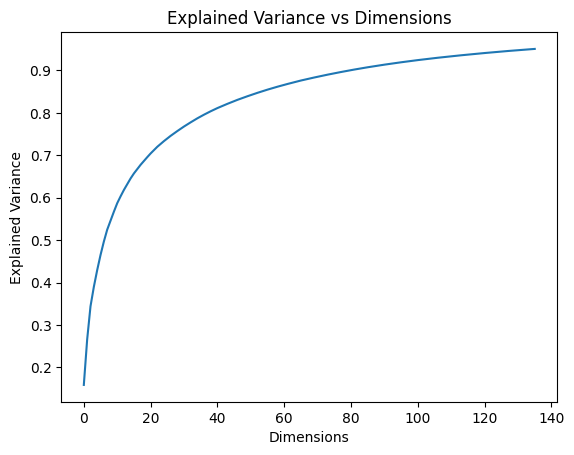

In [ ]:
# Make a pca on histograms df and visualize the elbow method
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
pca.fit(histograms_df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs Dimensions")
plt.show()

In [ ]:
# Transform the histograms_df with the pca
histograms_pca = pca.transform(histograms_df)

# Transform histograms pca into a dataframe
histograms_pca = pd.DataFrame(
    histograms_pca, columns=[f"hist_pca_{i}" for i in range(histograms_pca.shape[1])]
)

# Use the ARIs function to compute the ARI between the true categories and the clusters
ARI, X_tsne, labels, y_cat_ser = ARI_fct(histograms_pca)

ARI :  0.0007 time :  10.0


L'objet [`keypoints`](command:_github.copilot.openSymbolFromReferences?%5B%22keypoints%22%2C%5B%7B%22uri%22%3A%7B%22%24mid%22%3A1%2C%22fsPath%22%3A%22c%3A%5C%5CUsers%5C%5CBS6517%5C%5CDocuments_local%5C%5Cprojet_6%5C%5Coc_projet_6%5C%5C1_notebook_classification_072024.ipynb%22%2C%22_sep%22%3A1%2C%22external%22%3A%22vscode-notebook-cell%3A%2Fc%253A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%23Y320sZmlsZQ%253D%253D%22%2C%22path%22%3A%22%2Fc%3A%2FUsers%2FBS6517%2FDocuments_local%2Fprojet_6%2Foc_projet_6%2F1_notebook_classification_072024.ipynb%22%2C%22scheme%22%3A%22vscode-notebook-cell%22%2C%22fragment%22%3A%22Y320sZmlsZQ%3D%3D%22%7D%2C%22pos%22%3A%7B%22line%22%3A0%2C%22character%22%3A0%7D%7D%5D%5D "Go to definition") en OpenCV est une liste d'objets `cv2.KeyPoint`. Chaque objet `KeyPoint` représente un point d'intérêt détecté dans l'image et contient plusieurs attributs qui décrivent ce point. Voici les principaux attributs de l'objet `KeyPoint` :

1. **pt** : Un tuple (x, y) représentant la position du keypoint dans l'image.
2. **size** : La taille du keypoint, c'est-à-dire le diamètre du voisinage utilisé pour la détection.
3. **angle** : L'orientation du keypoint en degrés (de 0 à 360). Cela représente l'angle de la direction dominante du gradient autour du keypoint.
4. **response** : Une valeur de réponse qui indique la force du keypoint. Plus la valeur est élevée, plus le keypoint est fort.
5. **octave** : L'octave (échelle) dans laquelle le keypoint a été détecté. Cela est utilisé pour les algorithmes multi-échelles comme SIFT.
6. **class_id** : Un identifiant de classe optionnel pour le keypoint. Cela peut être utilisé pour des applications spécifiques où les keypoints doivent être classifiés.



In [ ]:
print(keypoints[0].pt)
print(keypoints[0].size)
print(keypoints[0].angle)
print(keypoints[0].response)
print(keypoints[0].octave)
print(keypoints[0].class_id)

(3.1131632328033447, 564.3240966796875)
2.396592140197754
179.27517700195312
0.06975063681602478
4129535
-1
